In [237]:
import pickle

from info_nas.datasets.arch2vec_dataset import prepare_labeled_dataset, split_off_valid
from info_nas.datasets.io.semi_dataset import labeled_network_dataset
from info_nas.datasets.io.transforms import get_transforms, get_all_scales
from info_nas.models.utils import load_extended_vae 

from info_nas.config import local_dataset_cfg, load_json_cfg

scale_cfg = '../configs/model_config.json'
scale_dir = '../data/scales/'

with open('../data/nasbench.pickle', 'rb') as f:
    nb = pickle.load(f)

# load all scaling
scale_cfg = load_json_cfg(scale_cfg)

scale_config = scale_cfg["scale"]
include_bias = scale_config["include_bias"]
normalize = scale_config["normalize"]
multiply_by_weights = scale_config["multiply_by_weights"]
use_scale_whole = scale_config["scale_whole"]

scale_train, scale_valid, scale_whole = get_all_scales(scale_dir, scale_config)
print(f"Scale paths: {scale_train}, {scale_valid}, {scale_whole}")

def get_data_scale(dataset, scale_name, split_ratio=0.9):
    transforms = get_transforms(scale_train if scale_name == "train" else scale_valid,
                                include_bias, normalize, multiply_by_weights,
                                scale_whole_path=scale_whole)
    
    scale = transforms.transforms[-2].after_sort_scale
    return scale

def get_data_loader(dataset, scale_name, split_ratio=0.9):
    transforms = get_transforms(scale_train if scale_name == "train" else scale_valid,
                                include_bias, normalize, multiply_by_weights,
                                scale_whole_path=scale_whole)
    transforms.transforms = transforms.transforms[:-1]

    key = 'val' if scale_name == 'valid' else scale_name
    dataset, _ = prepare_labeled_dataset(dataset, nb, key=key, remove_labeled=False,
                                         config=local_dataset_cfg)

    dataset = labeled_network_dataset(dataset, transforms=transforms, return_ref_id=True)
    data_loader = torch.utils.data.DataLoader(dataset, shuffle=False)
    
    return data_loader

Scale paths: ../data/scales/scale-train-include_bias.pickle, ../data/scales/scale-valid-include_bias.pickle, ../data/scales/whole_scale-axis_0-train-include_bias.pickle


In [10]:
import torch

train = get_data_loader('../data/train_long.pt', 'train')
valid = get_data_loader('../data/valid_long.pt', 'valid')
test_train = get_data_loader('../data/test_small_split.pt', 'train')
test_valid = get_data_loader('../data/test_valid_long.pt', 'valid')

Loading nasbench dataset (arch2vec) from ../data/nb_dataset.json
Loading labeled dataset from ../data/train_long.pt.
Loading nasbench dataset (arch2vec) from ../data/nb_dataset.json
Loading labeled dataset from ../data/valid_long.pt.
Loading nasbench dataset (arch2vec) from ../data/nb_dataset.json
Loading labeled dataset from ../data/test_small_split.pt.
Loading nasbench dataset (arch2vec) from ../data/nb_dataset.json
Loading labeled dataset from ../data/test_valid_long.pt.


In [238]:
import torch

train_scale = get_data_scale('../data/train_long.pt', 'train')
valid_scale = get_data_scale('../data/valid_long.pt', 'valid')
test_train_scale = get_data_scale('../data/test_small_split.pt', 'train')
test_valid_scale = get_data_scale('../data/test_valid_long.pt', 'valid')

In [11]:
import torch
from arch2vec.extensions.get_nasbench101_model import get_arch2vec_model

check_path = '/home/gabi/diplomka/results/with_ref_5/2021-20-07_23-26-03/model_dense_epoch-29.pt'

device = torch.device('cuda')

vae_model, _ = get_arch2vec_model(device=device)
args = [vae_model, 3, 513]
model, chdata = load_extended_vae(check_path, args, device=device)

In [136]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('model_visualization')
writer.add_graph(model, [batch['ops'].to(device), batch['adj'].to(device), batch['input'].to(device)])
writer.close()

In [135]:
for batch in train:
    pred = model(batch['ops'].to(device), batch['adj'].to(device), batch['input'].to(device))
    break
    
pred[-1].shape

torch.Size([1, 513])

In [130]:
import numpy as np

def filter_vals(data, val, by, val2, by2):
    hashes = []
    val_list = []
    val_list_2 = []
    
    pred_list = []
    pred_list_2 = []
    
    for i, batch in enumerate(data):
        if i % 10000 == 0:
            print(i)
        
        ref = batch[by]
        if ref == val:
            val_list.append(batch['output'].numpy()[0])
            
            pred = model(batch['ops'].to(device), batch['adj'].to(device), batch['input'].to(device))
            pred_list.append(pred[-1][0].detach().cpu().numpy())
            
        if batch[by2][0] == val2:
            hashes.append(batch['hash'])
            val_list_2.append(batch['output'].numpy()[0])
            
            pred = model(batch['ops'].to(device), batch['adj'].to(device), batch['input'].to(device))
            pred_list_2.append(pred[-1][0].detach().cpu().numpy())
            
    return val_list, val_list_2, pred_list, pred_list_2, hashes

    
im_train, hash_train, im_train_pred, hash_train_pred, hashes_train = filter_vals(train, 0, 'ref_id',
                                                                                 '4a6771dd03839135f5162c8a37ca2f5c',
                                                                                 'hash')

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000


In [55]:
im_val, hash_val, im_val_pred, hash_val_pred = filter_vals(valid, 0, 'ref_id',
                                                                   'ebfb58c962c08ebc3ff44c63937a823a',
                                                                   'hash')

0
10000
20000
30000
40000
50000
60000
70000


In [54]:
for batch in test_valid:
    print(batch['hash'])
    print(batch['ref_id'])
    break

['ebfb58c962c08ebc3ff44c63937a823a']
tensor([0])


In [56]:
im_tt, hash_tt, im_tt_pred, hash_tt_pred = filter_vals(test_train, 0, 'ref_id',
                                                                   '00ab8e9798743ca93dfe76e3a373ddff',
                                                                   'hash')

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000


In [57]:
im_tval, hash_tval, im_tval_pred, hash_tval_pred = filter_vals(test_valid, 0, 'ref_id',
                                                                   'ebfb58c962c08ebc3ff44c63937a823a',
                                                                   'hash')

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


In [272]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

#def plot_heatmap(hashes, im, hash_pred, im_pred, source_hashes):
def plot_heatmap(im, hashes, im_pred, hash_pred, title, scale_set, vmax=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,5))    
    cbar_ax = fig.add_axes([.91, .3, .01, .4])
    
    hashes = np.array(hashes) * scale_set['std'] + scale_set['mean']
    hash_pred = np.array(hash_pred) * scale_set['std'] + scale_set['mean']
    
    #hashes = hashes[:100]
    #hash_pred = hash_pred[:100]
    
    pred_max = np.max(hashes) if vmax is None else vmax
    pred_min = np.min(hashes)
    
    sns.heatmap(hashes, ax=ax1, vmin=-1.5, vmax=pred_max,  cbar=False)
    sns.heatmap(hash_pred, ax=ax2, vmin=-1.5, vmax=pred_max, cbar_ax=cbar_ax)
    plt.suptitle(f"Feature on images of 1 chosen network - {title}")
    fig.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig(f'{title}_samenet.png')
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,5))    
    cbar_ax = fig.add_axes([.91, .3, .01, .4])
        
    im = np.array(im) * scale_set['std'] + scale_set['mean']
    im_pred = np.array(im_pred) * scale_set['std'] + scale_set['mean']
    
    #im = im[50:100]
    #im_pred = im_pred[50:100]
    
    pred_max = np.max(im_pred)
    pred_min = np.min(im_pred)
    
    sns.heatmap(im, ax=ax1, vmin=pred_min, vmax=pred_max, cbar=False)
    sns.heatmap(im_pred, ax=ax2, vmin=pred_min, vmax=pred_max, cbar_ax=cbar_ax)
    plt.suptitle(f"Feature outputs on one image - {title}")
    fig.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig(f'{title}_sameim.png')
    plt.show()

<IPython.core.display.Javascript object>


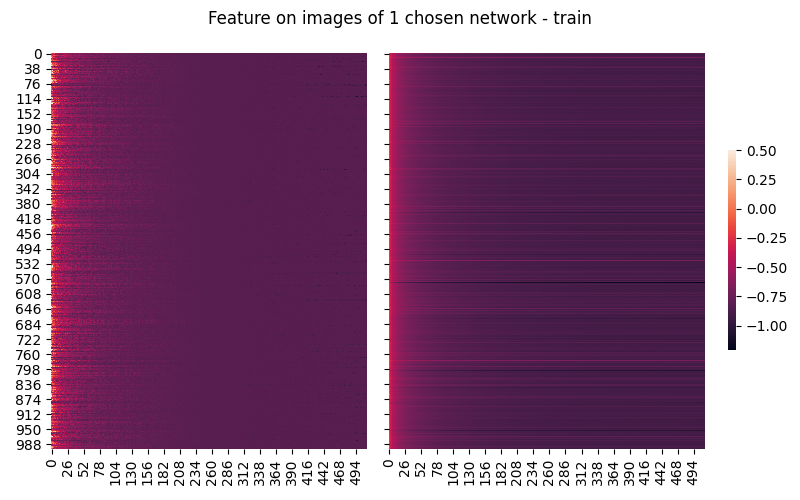

<ipython-input-235-339f98c068d2>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


<IPython.core.display.Javascript object>


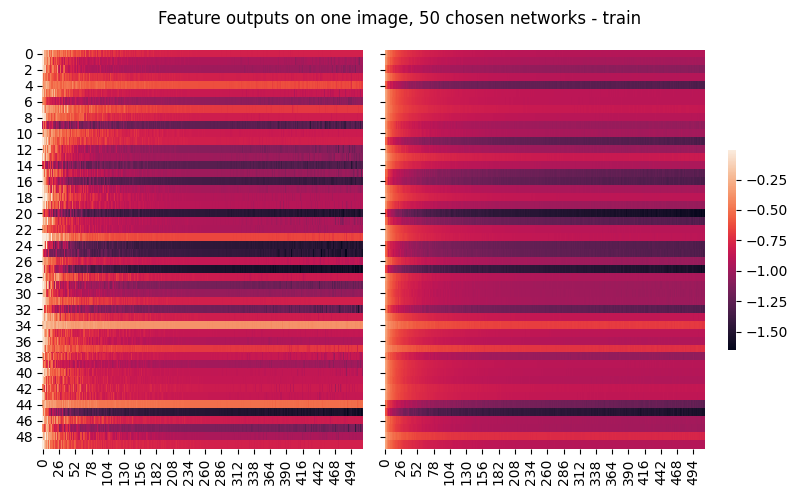

<ipython-input-235-339f98c068d2>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [236]:
plot_heatmap(im_train, hash_train, im_train_pred, hash_train_pred, 'train', train_scale)

<IPython.core.display.Javascript object>


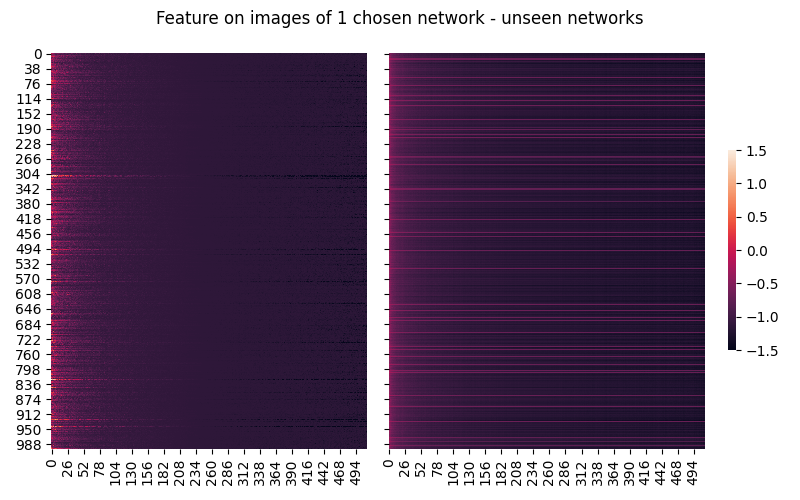

<ipython-input-272-3af0969a0ef1>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


<IPython.core.display.Javascript object>


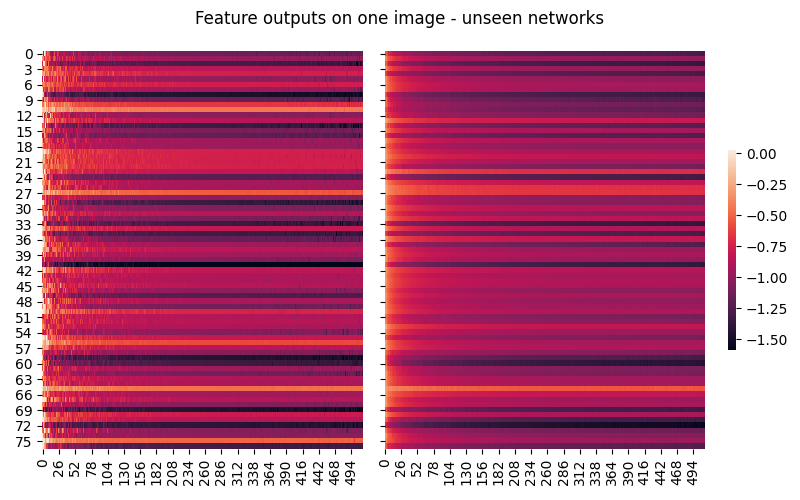

<ipython-input-272-3af0969a0ef1>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [273]:
plot_heatmap(im_val, hash_val, im_val_pred, hash_val_pred, 'unseen networks', valid_scale, vmax=1.5)

<IPython.core.display.Javascript object>


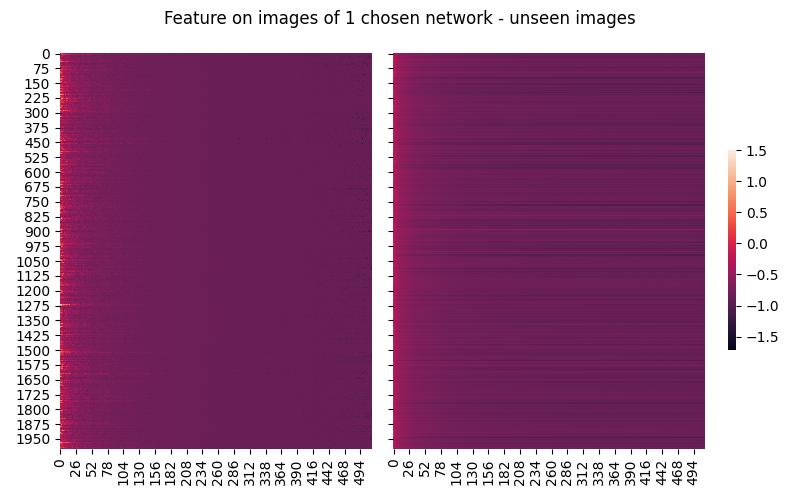

<ipython-input-265-4f0970c9d317>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


<IPython.core.display.Javascript object>


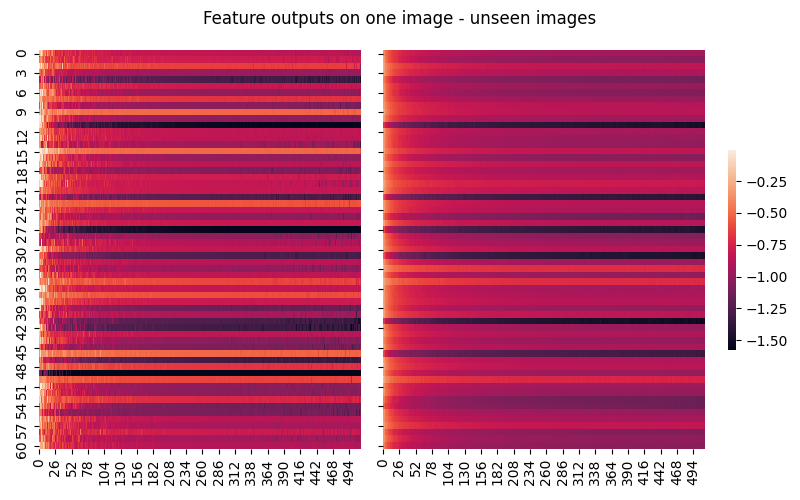

<ipython-input-265-4f0970c9d317>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [266]:
plot_heatmap(im_tt, hash_tt, im_tt_pred, hash_tt_pred, 'unseen images', test_train_scale, vmax=1.5)

<IPython.core.display.Javascript object>


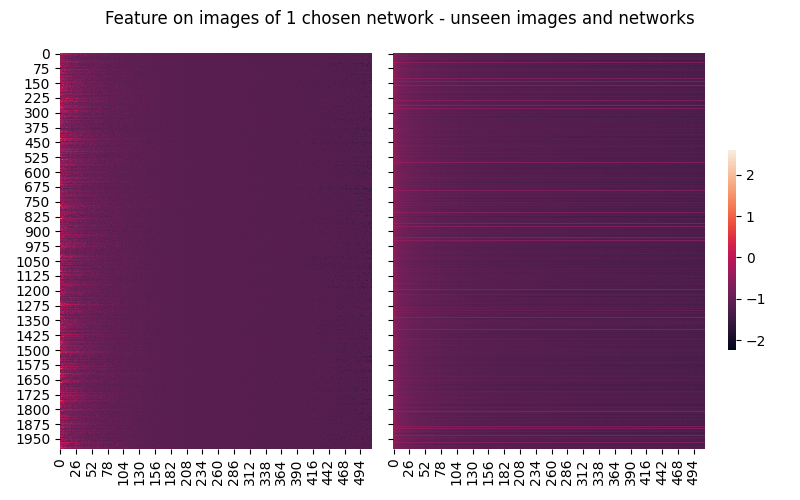

<ipython-input-253-4f0970c9d317>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


<IPython.core.display.Javascript object>


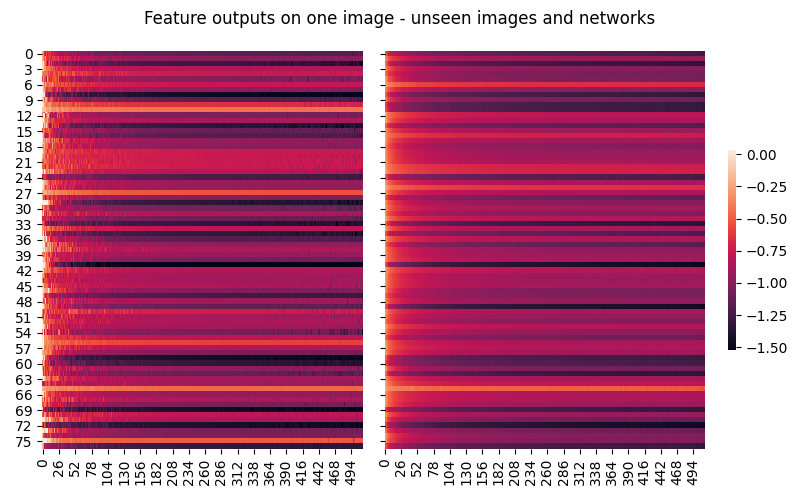

<ipython-input-253-4f0970c9d317>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [257]:
plot_heatmap(im_tval, hash_tval, im_tval_pred, hash_tval_pred, 'unseen images and networks', test_valid_scale
             )

In [128]:
transforms = get_transforms(scale_train,
                                include_bias, normalize, multiply_by_weights,
                                scale_whole_path=scale_whole)

scale = transforms.transforms[-2].after_sort_scale
bef_scale = transforms.transforms[1].net_scales
bef_scale

{'0007522357ab851ea74abae9fb2d15c1': {'mean': 0.3380475544949971,
  'std': 0.32142944992604017,
  'max': 3.127687692642212},
 '00261a9591b593ceb68cd5854744e807': {'mean': 0.3204536681843423,
  'std': 0.3969353384762228,
  'max': 3.792530059814453},
 '00961d039703aa88c0eb5faa0889a64e': {'mean': 0.3361174243522686,
  'std': 0.3327575382914572,
  'max': 4.138679504394531},
 '00ab8e9798743ca93dfe76e3a373ddff': {'mean': 0.37217891573769774,
  'std': 0.44530000244776186,
  'max': 6.678936958312988},
 '00ac1ec7a2d74d205a5f2b6bce0158f0': {'mean': 0.35255073381394986,
  'std': 0.45504896044511883,
  'max': 6.784005165100098},
 '01e1e6d0a7260e29e06567650feb078c': {'mean': 0.32902812921634916,
  'std': 0.29197192796892124,
  'max': 3.1305325031280518},
 '01ef56131803d7e4e79399d675ea0b42': {'mean': 0.32253157561253754,
  'std': 0.3862012033124631,
  'max': 3.832611083984375},
 '023bfb8418a28942ee4a9734e373ca67': {'mean': 0.3207386591474787,
  'std': 0.4097397659615605,
  'max': 4.574634075164795},

<IPython.core.display.Javascript object>


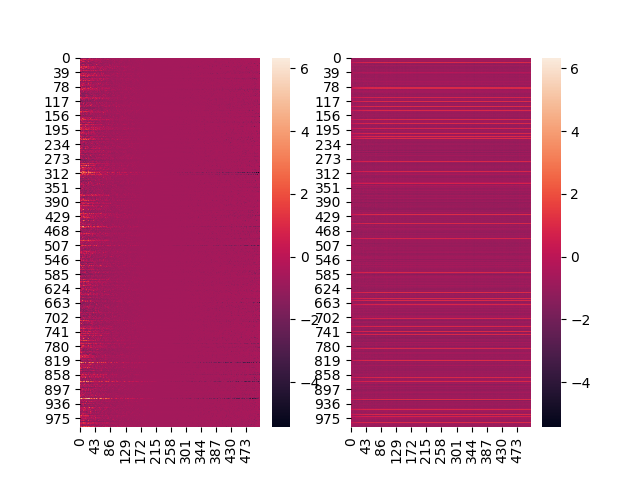

In [122]:
plot_heatmap(im_val, hash_val, im_val_pred, hash_val_pred)

In [ ]:
# learned the unique weight signature